In [1]:
# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib.gridspec as gridspec

# home brew utitilties
import resources.utility_functions as ut
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display, Math, Latex

plt.ion()

# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2020-03-01'
end_date ='2021-10-01'

author = "analyst@hammerdirt"


# set the fail rate to test
a_fail_rate = 50

# name of the output folder:
name_of_project = 'alpes-valaisannes'

# set the maps
bassin_map = PILImage.open("resources/maps/alpesvalaisannes.jpeg")
land_use_map = PILImage.open("resources/maps/land_use_aare.jpeg")

# the search term for the river bassin
bassin_name = 'les-alpes'

# use water_name_slug
lakes_of_interest = ['alpes-']
lake_colors=["darkblue", 'aquamarine', 'dodgerblue', 'teal']

# the names for the survey area and the cumulative data
level_names = ["Les Alpes","All survey areas"]

# the scale for pieces per meter and the column and chart label for the units
reporting_unit = 100
unit_label = 'p/100m'

# add the folder to the directory tree:
project_directory = ut.make_project_folder('output', name_of_project)

# colors for gradients
colors = ['beige', 'navajowhite', 'tan', 'sandybrown','coral', 'salmon', 'sienna', 'maroon','red']
nodes = [0.0, 0.12, 0.24, 0.36, 0.48, 0.6, 0.72, 0.84, 1.0]
cmap2 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

# get your data:
aldata = pd.read_csv("resources/checked_alpes_survey_data.csv")
sdata = pd.read_csv("resources/checked_sdata_eos_2020_21.csv")
survey_data = pd.concat([aldata, sdata])
river_bassins = ut.json_file_get("resources/river_basins.json")
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
dfDims = pd.read_csv("resources/corrected_dims.csv")

# set the index of the beach data to location slug
alpb = dfBeaches[dfBeaches.river_bassin == 'les-alpes'].copy()
alpb = dfBeaches[dfBeaches.river_bassin == 'les-alpes'].copy()
alpb['slug'] = alpb.slug.apply(lambda x: x.replace('clean-up-tour-', ''))
dfBeaches = pd.concat([alpb, dfBeaches[dfBeaches.river_bassin != 'les-alpes']])
dfBeaches.set_index('slug', inplace=True)

# map locations to feature names
location_wname_key = dfBeaches.water_name_slug

# map water_name_slug to water_name
# wname_wname = dfBeaches[['water_name_slug','water_name']].reset_index(drop=True).drop_duplicates()
# wname_wname.set_index('water_name_slug', inplace=True)

# convenience function for doing land use correlations
def make_plot_with_spearmans(data, ax, n):
    sns.scatterplot(data=data, x=n, y=unit_label, ax=ax, color='black', s=30, edgecolor='white', alpha=0.6)
    corr, a_p = stats.spearmanr(data[n], data[unit_label])
    return ax, corr, a_p

# index the code data
dfCodes.set_index("code", inplace=True)

# these descriptions need to be shortened for display
dfCodes = sut.shorten_the_value(["G74", "description", "Insulation: includes spray foams"], dfCodes)
dfCodes = sut.shorten_the_value(["G940", "description", "Foamed EVA for crafts and sports"], dfCodes)
dfCodes = sut.shorten_the_value(["G96", "description", "Sanitary-pads/tampons, applicators"], dfCodes)
dfCodes = sut.shorten_the_value(["G178", "description", "Metal bottle caps and lids"], dfCodes)
dfCodes = sut.shorten_the_value(["G82", "description", "Expanded foams 2.5cm - 50cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G81", "description", "Expanded foams .5cm - 2.5cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G117", "description", "Expanded foams < 5mm"], dfCodes)
dfCodes = sut.shorten_the_value(["G75", "description", "Plastic/foamed polystyrene 0 - 2.5cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G76", "description", "Plastic/foamed polystyrene 2.5cm - 50cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G24", "description", "Plastic lid rings"], dfCodes)
dfCodes = sut.shorten_the_value(["G33", "description", "Lids for togo drinks plastic"], dfCodes)
dfCodes = sut.shorten_the_value(["G3", "description", "Plastic bags, carier bags"], dfCodes)
dfCodes = sut.shorten_the_value(["G204", "description", "Bricks, pipes not plastic"], dfCodes)

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code descriptions
code_material_map = dfCodes.material

(lesalpes)=

# The Alpes and the Jura

The Alpes and the Jura (les Alpes) is a survey area configured and managed by the Summit Foundation. The Summit Foundation conducts [clean up events](https://www.summit-foundation.org/en/) throughout the Swiss Alpes as part of the summer clean up tour a series of litter-surveys were conducted. Specifically they wanted to answer two questions:

1. How can data collection be integrated into the current business model
2. How do surveys conducted on mountain trails compare to those on the waters edge

The purpose of the clean up events are to remove as much debris as possible from a defined area, the limits on how much can be removed is related to the resources at hand. A litter survey is concerned with what exactly is being found and maintaining a count of the objects within a defined area. In this sense a clean-up event is approaching the litter problem from the perspective of attenuation or mitigation and the litter-survey is providing the data necessary to improve prevention.

## Survey methods

In total there were twenty litter-surveys conducted by Summit foundation. Initially two methods were selected:

1. Survey a section of trail for a defined distance and width
2. Survey the arrival/departure of the lift line

The survey procedure remains the same under both conditions:

1. A section of trail or surface area is measured
2. All visible pollutants are removed counted and classified.
3. The results and dimensions are recorded

The difference between the two methods is the way the limits of survey area are defined. When a trail is used the limits of the survey area are defined by the trail itself, not the surveyor. In the summer time the barriers and signs that mark out the areas for lift lines have all been removed, making it difficult for the surveyor to accurately determine the correct limits.

## Survey area cumulative totals

*Map of survey area _Les Alpes_, summer clean up tour 2021*


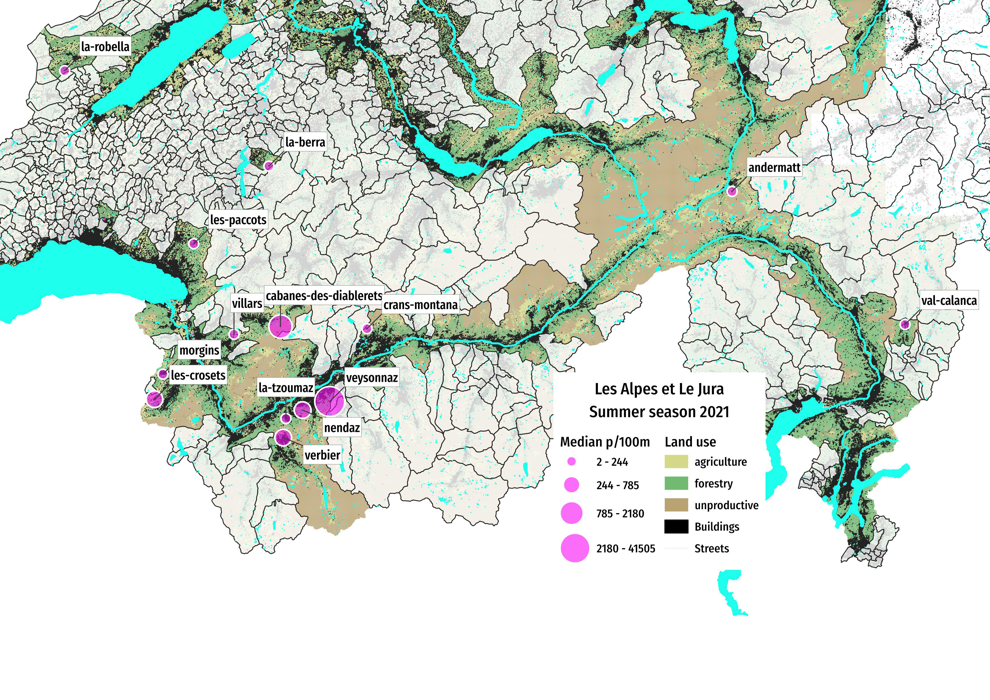

In [2]:
output = io.BytesIO()
bassin_map.thumbnail((1200, 700))
bassin_map.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
IPython.display.HTML(html)

In [3]:
# define the final survey data set here:
a_data = survey_data.copy()

# convert string dates from .csv to timestamp
a_data['date']=pd.to_datetime(a_data['date'], format='%Y-%m-%d')

# slice by start - end date
a_data = a_data[(a_data.date >= start_date)&(a_data.date <= end_date)]

In [4]:

# remove prefixes from survey data
lalpes = a_data[a_data.river_bassin == 'les-alpes'].copy()
lalpes['location'] = lalpes.location.apply(lambda x: x.replace('clean-up-tour-', ''))
alocs = lalpes.location.unique()
alocs

array(['cabanes-des-diablerets', 'val-calanca', 'san-bernardino',
       'airolo', 'nendaz', 'veysonnaz', 'andermatt', 'verbier',
       'crans-montana', 'villars', 'les-crosets', 'morgins', 'la-berra',
       'grindelwald', 'la-tzoumaz', 'la-robella', 'les-diablerets',
       'charmey', 'monte-generoso', 'les-paccots'], dtype=object)

In [5]:


lalpes['location'] = lalpes.location.apply(lambda x: x.replace('clean-up-tour-', ''))
a_data = pd.concat([lalpes, a_data[a_data.river_bassin != 'les-alpes']])

# remove prefixes from dims data 
dalpes = dfDims[(dfDims.river_bassin == 'les-alpes')&(dfDims.date >= start_date)&(dfDims.date <= end_date)].copy()
dalpes['location'] = dalpes.location.apply(lambda x: x.replace('clean-up-tour-', ''))
dfDims = pd.concat([dalpes, dfDims[dfDims.river_bassin != 'les-alpes']])

# make a loc_date column from the survey data
a_data['loc_date']=tuple(zip(a_data.location, a_data.date))

# scale the streets to kilometers
a_data['streets'] = a_data.streets.astype('int')

# save the data before aggregating to test
before_agg = pd.read_csv("resources/checked_alpes_survey_data_be.csv")

# a common aggregation
agg_pcs_quantity = {unit_label:'sum', 'quantity':'sum'}

# the daily survey totals of all the data for the survey period
a_dt = a_data.groupby(['loc_date', 'date',"location"], as_index=False).agg(agg_pcs_quantity)

# define the feature data
fd = a_data[(a_data.river_bassin == 'les-alpes')].copy()

# the totals for each survey and the locations in the feature data
fd_dt=fd.groupby(['loc_date', 'date','month', 'location'], as_index=False).agg(agg_pcs_quantity)

# the unique locations and samples
fd_locs = fd.location.unique()
fd_samps = fd.loc_date.unique()

# gather the dimensional data for the time frame from dfDims
# match records to survey data
fd_dims= dfDims.copy()

# make a loc_date column and get the unique values
fd_dims['loc_date'] = list(zip(fd_dims.location, fd_dims.date))

# key the quantity from the survey totals to the dimensional data
try_this = {(x[0],dt.datetime.strftime(x[1].to_pydatetime(), "%Y-%m-%d")):fd_dt[fd_dt.loc_date == x]['quantity'].to_numpy()[0] for x in fd_dt.loc_date.unique()}

# map quantity per survey to the dims data
fd_dims['quantity'] = fd_dims.loc_date.map(lambda x: ut.use_this_key(x, try_this))

# keep the dims that did not get tagged with a qty
no_qty = fd_dims[fd_dims.quantity == 'bad key']

# drop the dims that did not match
som_dims = fd_dims[fd_dims.quantity != 'bad key'].copy()

# identify the surveys with no matching dimensional data
no_matching_dim_records = [x for x in list(fd_samps) if x not in list(fd_dims.loc_date.unique())]

# survey totals
dt_all = a_data.groupby(['loc_date','location','river_bassin', 'date'], as_index=False).agg(agg_pcs_quantity)

# gather the municpalities and the population:
fd_pop_map = dfBeaches.loc[fd.location.unique()][['city','population']].copy()
fd_pop_map.drop_duplicates(inplace=True)
fd_pop_map.set_index('city', drop=True, inplace=True)

# code totals for the river bassin
fd_code_t= fd.groupby(['code', 'groupname'], as_index=False).agg({'quantity':'sum', 'fail':'sum', unit_label:'median'})
fd_code_t.rename(columns={"groupname":'utility'}, inplace=True)
fd_code_t["% of total"] = fd_code_t.quantity/fd_code_t.quantity.sum()
fd_code_t.set_index('code', inplace=True)
fd_code_t.sort_values(by='quantity', ascending=False, inplace=True)
fd_code_t['material'] = fd_code_t.index.map(lambda x: code_material_map[x])
fd_code_t['item'] = fd_code_t.index.map(lambda x: code_description_map.loc[x])
fd_code_t["% of total"] = (fd_code_t["% of total"]*100).round(1)
fd_code_t["fail rate"] = ((fd_code_t["fail"]/len(fd.loc_date.unique()))*100).round(1)

# objects with a fail rate of > 50% in the survey area
most_common = fd_code_t[fd_code_t["fail rate"] > 50].sort_values(by='quantity', ascending=False)

# material totals:
fd_mat_t = fd_code_t[['material', 'quantity']].groupby('material', as_index=False).quantity.sum()
fd_mat_t["% of total"] = fd_mat_t.quantity/fd_mat_t.quantity.sum()

# map total quantity per feature:
qty_all_features = fd.groupby("location").quantity.sum()

# summary statistics:
fd_n_samps = len(fd_samps)
fd_n_obj = fd.quantity.sum()
fd_n_locs = len(fd_locs)
fd_n_munis = len(fd_pop_map.index)
fd_effected_population = fd_pop_map.sum()

lakes = dfBeaches.loc[(dfBeaches.index.isin(fd_locs))&(dfBeaches.water == 'l')]['water_name'].unique()
rivers = dfBeaches.loc[(dfBeaches.index.isin(fd_locs))&(dfBeaches.water == 'r')]['water_name'].unique()

obj_string = '{:,}'.format(fd_n_obj)
surv_string = '{:,}'.format(fd_n_samps)
pop_string = '{:,}'.format(int(fd_effected_population[0]))

date_quantity_context = F"For the period between {start_date[:-3]} and {end_date[:-3]}, {obj_string } objects were removed and identified in the course of {surv_string} surveys."
geo_context = F"Those surveys were conducted at {fd_n_locs} different locations."
admin_context = F"There are {fd_n_munis} different municipalities included with a combined population of $\\approx$ {pop_string}."
munis_joined = ', '.join(sorted(fd_pop_map.index))

# put that all together:
lake_string = F"""
{date_quantity_context} {geo_context } {admin_context}

\n\n{munis_joined}"""

In [6]:
fd.location.unique()

array(['cabanes-des-diablerets', 'val-calanca', 'san-bernardino',
       'airolo', 'nendaz', 'veysonnaz', 'andermatt', 'verbier',
       'crans-montana', 'villars', 'les-crosets', 'morgins', 'la-berra',
       'grindelwald', 'la-tzoumaz', 'la-robella', 'les-diablerets',
       'charmey', 'monte-generoso', 'les-paccots'], dtype=object)

In [7]:
md(lake_string)


For the period between 2020-03 and 2021-10, 7,776 objects were removed and identified in the course of 20 surveys. Those surveys were conducted at 20 different locations. There are 18 different municipalities included with a combined population of $\approx$ 70,606.



Airolo, Andermatt, Calanca, Châtel-Saint-Denis, Grindelwald, La Roche, Lens, Mesocco, Nendaz, Ollon, Ormont-Dessus, Riddes, Rovio, Troistorrents, Val de Bagnes, Val-d'Illiez, Val-de-Charmey, Val-de-Travers

### Sample totals

The beach-litter survey results from the clean-up events.

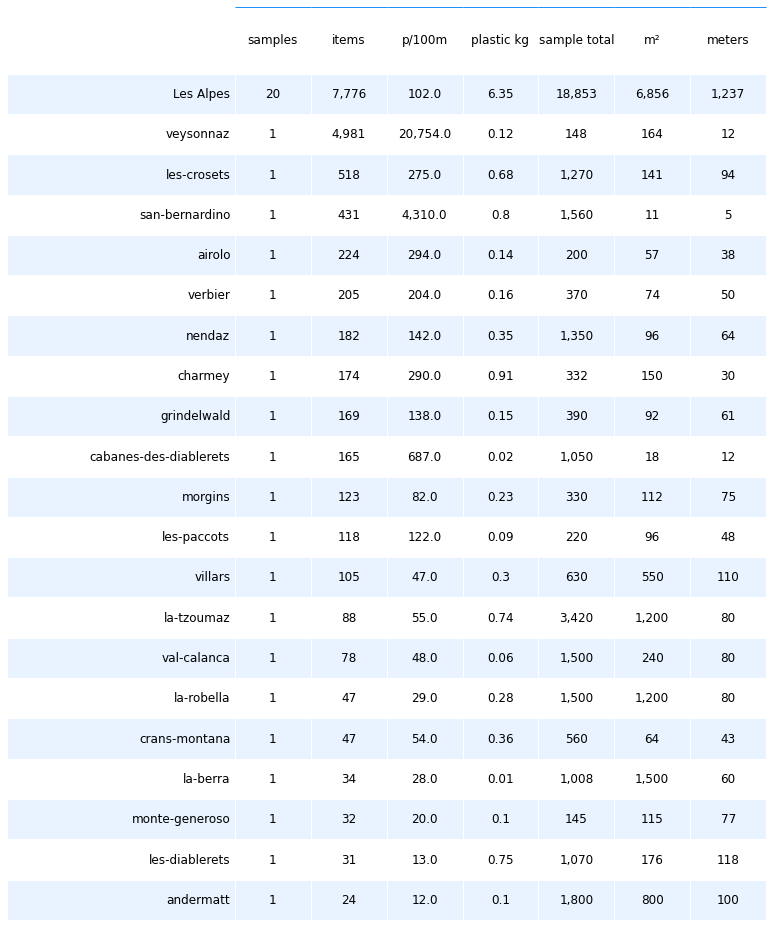

In [8]:
# aggregate the dimensional data down to the lake or river
som_dims[unit_label] = ((som_dims.quantity/som_dims.length)*50).astype('int')

agg_for_table = {
    'quantity':'sum',
    unit_label:'mean',
    'total_w':'sum',
    'mac_plast_w':'sum',
    'mic_plas_w':'sum',
    'area':'sum',
    'length':'sum',
    'num_parts_other':'sum',
    'num_parts_staff':'sum',
    'time_minutes':'sum'
    
}

dims_table = som_dims.groupby(["location"]).agg(agg_for_table )

# collect the number of samples from the survey total data:
for name in dims_table.index:
    dims_table.loc[name, 'samples'] = fd_dt[fd_dt.location == name].loc_date.nunique()

# get the sum of all survey areas
dims_table.loc["Les Alpes"]= dims_table.sum(numeric_only=True, axis=0)

dims_table.loc["Les Alpes", unit_label] = som_dims.groupby(["location"])[unit_label].sum().median()

# for display
dims_table.sort_values(by=["quantity"], ascending=False, inplace=True)
dims_table.rename(columns={'samples':'samples','quantity':'items', 'total_w':'total kg', unit_label:unit_label, 'mac_plast_w':'plastic kg', 'mic_plas_w':'sample total', 'area':'m²', 'length':'meters'}, inplace=True)

# order the columns
dims_table = dims_table[['samples', *dims_table.columns[:-1]]]

# format kilos
dims_table['plastic kg'] = dims_table['plastic kg']/1000

# format for printing
dims_table.rename(columns={'num_parts_other':'participants', 'num_parts_staff':'staff', 'time_minutes':'time'}, inplace=True)

# numerical types and columns
tints = ['samples', 'items', 'total kg', 'sample total', 'm²', 'participants', 'staff', 'time', 'meters']
twodec = [unit_label, 'plastic kg' ]

dims_table[tints] = dims_table[tints].astype('int')
dims_table[twodec] = dims_table[twodec].round(2)
dims_table['time'] = (dims_table['time']/60).astype('int')

commas = ['items','total kg', 'sample total', 'meters', 'm²', unit_label]

dims_table[commas] = dims_table[commas].applymap(lambda x: F"{x:,}")

# table one
data = dims_table.reset_index()
table_one = dims_table[['samples', 'items',unit_label,"plastic kg","sample total", "m²", "meters"]].copy()
table_one.reset_index(inplace=True, )

a_color='dodgerblue'

fig, axs = plt.subplots(figsize=(len(table_one.columns)*1.7,len(table_one)*.8))
ut.hide_spines_ticks_grids(axs)

the_first_table_data = axs.table(table_one.values,  colLabels=table_one.columns, colWidths=[.3, *[.1]*7], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,table_one.values,table_one.columns, a_color, s_et_bottom_row=False)

a_summary_table_one.get_celld()[(0,0)].get_text().set_text(" ")

plt.show()
plt.tight_layout()
plt.close()

### Event totals

The total amount of trash removed and number of participants.

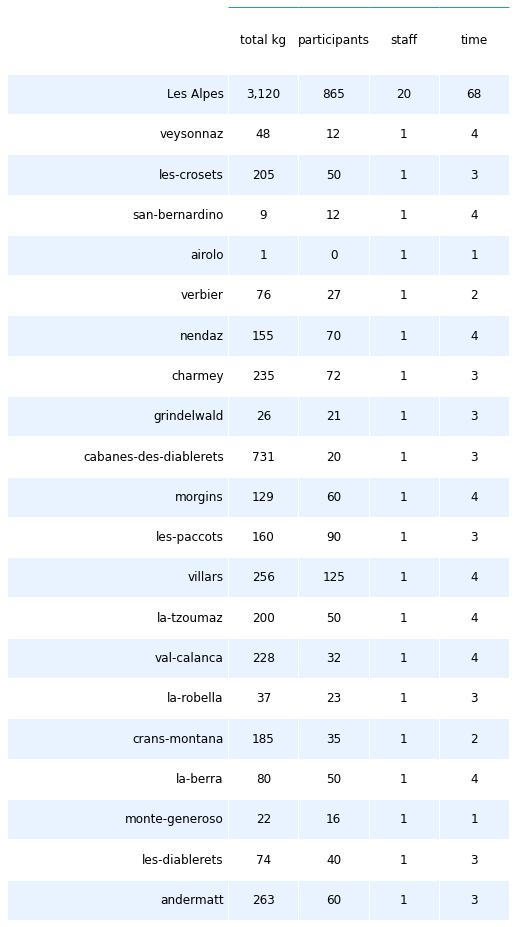

In [9]:
# table two event totals
table_two = dims_table[["total kg", "participants","staff", "time"]].copy()
table_two.reset_index(inplace=True, )

fig, axs = plt.subplots(figsize=(len(table_two.columns)*1.8,len(table_one)*.8))
ut.hide_spines_ticks_grids(axs)

the_first_table_data = axs.table(table_two.values,  colLabels=table_two.columns, colWidths=[.44, *[.14]*4], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,table_two.values,table_two.columns, a_color, s_et_bottom_row=False)

a_summary_table_one.get_celld()[(0,0)].get_text().set_text(" ")

plt.show()
plt.tight_layout()
plt.close()

## Land use profile of the survey locations

The land use profile is the percent of total area attributed to each land use category within a 1500m radius of each survey location.

1. \% of land attributed to buildings
2. \% of land attributed to agriculture
3. \% of land attributed to forestry
4. \% of land attributed to recreation

Streets are reported as the total number of kilometers of streets within the 1500m radius. Intersects is an ordinal ranking of the number of rivers/canals that intersect a lake within 1500m of the survey location.

The ratio of the number of samples completed at the different land use profiles is an objective indicator of the overall environmental and economic conditions that the samples were taken in. The distribution of the land use profile of all the surveys from the IQAASL project is used as a reference value.

See the section [*The land use profile*](luseprofile) for more details.

In [10]:
# explanatory variables:
luse_exp = ['% to buildings', '% to recreation', '% to agg', '% to woods', 'streets', 'intersects']

# columns needed
use_these_cols = ['loc_date' ,'% to buildings', '% to trans', '% to recreation', '% to agg', '% to woods','population','location','streets', 'intersects', 'groupname','code']
# lakes_s = dfBeaches.loc[(dfBeaches.index.isin(fd_locs))&(dfBeaches.water == 'l')]['location'].unique()

# the land use data of region in question
dfdt = fd.groupby(use_these_cols[:-2], as_index=False).agg(agg_pcs_quantity)

# figure caption
site_string = F"""
*{level_names[0]}: land use attributes of the survey locations. Distribution of samples with respect to land use.* 
"""
md(site_string)


*Les Alpes: land use attributes of the survey locations. Distribution of samples with respect to land use.* 


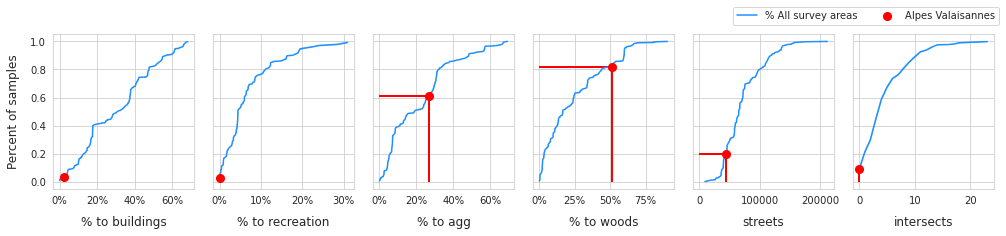

In [11]:
sns.set_style("whitegrid")

fig, axs = plt.subplots(1,len(luse_exp), figsize=(14,3), sharey=True)

# the land use data of the reference value
datax = a_data.groupby(use_these_cols[:-2], as_index=False).agg(agg_pcs_quantity)

# work off the copy
data = dfdt.copy()

for i, n in enumerate(luse_exp):    
    
    ax=axs[i]    
    # get the empirical distribution of the independent variable
    the_data = ECDF(datax[n].values)
        
    # plot that
    sns.lineplot(x=the_data.x, y=the_data.y, ax=ax, color='dodgerblue', label="% All survey areas")
    
    # get the median from region of interest
    the_median = data[n].median()
    
    # get its position reference the surrounding survey area
    a = (stats.percentileofscore(the_data.x, the_median))/100
    
    # plot the median and drop horzontal and vertical lines
    ax.scatter([the_median], a, color='red',s=50, linewidth=2, zorder=100, label="Alpes Valaisannes")
    ax.vlines(x=the_median, ymin=0, ymax=a, color='red', linewidth=2)
    ax.hlines(xmax=the_median, xmin=0, y=a, color='red', linewidth=2)
    
    # save the handels and labels but remove them from the ax    
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    
    # format the % of total on the xaxis:
    if i <= 3:
        if i == 0:            
            ax.set_ylabel("Percent of samples", **ck.xlab_k)
        ax.xaxis.set_major_formatter(ticker.PercentFormatter(1.0, 0, '%'))        
    else:
        pass
    ax.set_xlabel(n, **ck.xlab_k)

plt.tight_layout()
fig.legend(handles, labels, bbox_to_anchor=(1,1.1), loc='upper right', ncol=2)
plt.show()

The locations in the Alpes survey area had a higher percentage of land attributed to forestry and aggriculture and a lower percentage of land attributed to buildings and recreation than the locations in IQAASL.

The aggregated results demonstrate the difference between the two survey methods. The two locations with the highest p/100m (veysonnaz and cabanes-des-diablerets) also have the shortest length. In the case of cabanes-des-diablerets the meter² is equal to the length, suggesting that a small area was done around a structure or building. Veysonnaz is the arrival of a ski lift line.

The difference in methods produces markedly different results. Furthermore, these two locations were selected specifically for inventory because of the surveyors previous experiences. Because of the differences in dimensions and methods the survey results from veysonnaz and cabanes-des-diablerets are not considered in the proceeding analysis.

## Survey results walking trails

The survey results at Veysonnaz and Cabanes-des-Diablerets are excluded from this analysis based on the findings of the aggregated results.

In [12]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
fd_dt.location.unique()

In [ ]:
remove = ['veysonnaz', 'cabanes-des-diablerets', 'san-bernardino']

data =fd_dt[~fd_dt.location.isin(remove)].copy()

nvsn = data.location.unique()

# make a df of survey totals with date as index
# only the surveys from all other survey areas
dts_date = a_dt[(~a_dt.location.isin([*nvsn, *remove]))].copy()

# figure caption
chart_notes = F"""
*__Left:__ All survey areas, {start_date[:7]} through {end_date[:7]}, n=403. All samples lakes/rivers and walking trails*
"""
md(chart_notes )

In [ ]:
# months locator, can be confusing
# https://matplotlib.org/stable/api/dates_api.html
months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter('%b')
days = mdates.DayLocator(interval=7)

fig, axs = plt.subplots(1,2, figsize=(10,5))

ax = axs[0]

# there is a big value in here, that should be seen.
sns.scatterplot(data=dts_date, x='date', y=unit_label, color='black', alpha=0.4, label=level_names[1], ax=ax)
sns.scatterplot(data=data, x='date', y=unit_label, color='red', s=34, ec='white',label="Walking trails", ax=ax)

ax.set_xlabel("")
ax.set_ylabel(unit_label, **ck.xlab_k14)

ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)

axtwo = axs[1]

box_props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'magenta'},
    'medianprops':{'color':'magenta'},
    'whiskerprops':{'color':'magenta'},
    'capprops':{'color':'magenta'}
}
sns.boxplot(data=dts_date, y=unit_label, color='black',  ax=axtwo, showfliers=False, **box_props, zorder=1)
sns.stripplot(data=dts_date[dts_date[unit_label] <= 1000], s=10, y=unit_label, color='black', ax=axtwo, alpha=0.5, jitter=0.3, zorder=0)
sns.stripplot(data=data, y=unit_label, color='red', s=10, ec='white',linewidth=1, ax=axtwo, jitter=0.3, zorder=2)

axtwo.set_xlabel("")
axtwo.set_ylabel(unit_label, **ck.xlab_k14)

axtwo.xaxis.set_minor_locator(days)
axtwo.xaxis.set_major_formatter(months_fmt)

plt.tight_layout()
plt.show()
plt.close()

*__Right:__ Distribution of survey results, outliers removed.* 

### Summary data and material types

In [ ]:
# figure caption
summary_of_survey_totals = F"""
*__Left:__ Walking trails summary of survey totals*
"""
md(summary_of_survey_totals)

In [ ]:
data

In [ ]:
# the labels for the summary table:
change_names = {'count':'# samples', 
                'mean':F"average {unit_label}",
                'std':'standard deviation', 
                'min p/50m':'min', '25%':'25%',
                '50%':'50%', '75%':'75%',
                'max':F"max {unit_label}", 'min':F"min {unit_label}",
                'total objects':'total objects',
                '# locations':'# locations',
                'survey year':'survey year'
               }

# convenience function to change the index names in a series
def anew_dict(x):
    new_dict = {}
    for param in x.index:
        new_dict.update({change_names[param]:x[param]})
    return new_dict  

# select data
# data =fd_dt[fd_dt.location != 'veysonnaz'].copy()

# get the basic statistics from pd.describe
desc_2020 = data[unit_label].describe().round(2)

# add project totals
desc_2020['total objects'] = data.quantity.sum()
desc_2020['# locations'] = fd.location.nunique()

# change the names
combined_summary = pd.Series(anew_dict(desc_2020))

# format the output for printing:
not_formatted = combined_summary[-1]
combined_summary = [(x, "{:,}".format(int(combined_summary[x]))) for x in combined_summary.index[:-1]]
combined_summary.append((desc_2020.index[-1], int(not_formatted) ))

# make tables
fig, axs = plt.subplots(1,2, figsize=(8,6))

# summary table
# names for the table columns
a_col = [level_names[0], 'total']

axone = axs[0]
ut.hide_spines_ticks_grids(axone)

a_table = axone.table(cellText=combined_summary[:-1],  colLabels=a_col, colWidths=[.5,.25,.25], loc='lower center', bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,combined_summary[:-1],a_col, s_et_bottom_row=False)

# material table
axtwo = axs[1]
axtwo.set_xlabel(" ")
ut.hide_spines_ticks_grids(axtwo)
data = fd_mat_t.copy()

# column names for display
cols_to_use = {'material':'Material','quantity':'Quantity', '% of total':'% of total'}

# sort data before formatting
data.sort_values(by='quantity', inplace=True, ascending=False)

# format results
data['% of total'] =(data['% of total']*100).round(1)
data['quantity']=data.quantity.map(lambda x: '{:,}'.format(x))
data['% of total']=data['% of total'].map(lambda x:F"{x}%")

a_table = axtwo.table(cellText=data.values,  colLabels=list(cols_to_use.values()), colWidths=[.4, .3,.3], loc='lower center', bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,data,list(cols_to_use.values()), s_et_bottom_row=False)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.show()

In [ ]:
# figure caption
material_type = F"""
*__Right:__ Walking trails material type and percent of total*
"""
md(material_type)

### The most common objects

The most common objects are **the ten most abundant by quantity found** AND/OR **any object that was indentified in at least 50% of all the surveys**. 

In [ ]:
# code totals for les alpes not including veysonnaz
fd_code_t= fd[~fd.location.isin(remove)].groupby(['code', 'groupname'], as_index=False).agg({'quantity':'sum', 'fail':'sum', unit_label:'median'})
fd_code_t.rename(columns={"groupname":'utility'}, inplace=True)
fd_code_t["% of total"] = fd_code_t.quantity/fd_code_t.quantity.sum()
fd_code_t.set_index('code', inplace=True)
fd_code_t.sort_values(by='quantity', ascending=False, inplace=True)
fd_code_t['material'] = fd_code_t.index.map(lambda x: code_material_map[x])
fd_code_t['item'] = fd_code_t.index.map(lambda x: code_description_map.loc[x])
fd_code_t["% of total"] = (fd_code_t["% of total"]*100).round(1)
fd_code_t["fail rate"] = ((fd_code_t["fail"]/len(fd.loc_date.unique()))*100).round(1)

# objects with a fail rate of > 50% in the survey area
most_common = fd_code_t[fd_code_t["fail rate"] >= 50].sort_values(by='quantity', ascending=False)

# the top ten by quantity
most_abundant = fd_code_t.sort_values(by='quantity', ascending=False)[:10]

# merge with most_common and drop duplicates
m_common = pd.concat([most_abundant, most_common]).drop_duplicates()

# get percent of total
m_common_percent_of_total = m_common.quantity.sum()/fd_code_t.quantity.sum()

# figure caption
rb_string = F"""
*Walking trails most common objects: fail rate > {a_fail_rate}%  and/or top ten by quantity. 
Combined, the ten most abundant objects represent {int(m_common_percent_of_total*100)}% of all objects found, {unit_label}: median survey value.*
"""
md(rb_string)

In [ ]:
# format values for table
m_common['item'] = m_common.index.map(lambda x: code_description_map.loc[x])
m_common['% of total'] = m_common["% of total"].map(lambda x: F"{x}%")
m_common['quantity'] = m_common.quantity.map(lambda x: '{:,}'.format(x))
m_common['fail rate'] = m_common['fail rate'].map(lambda x: F"{x}%")
m_common[unit_label] = m_common[unit_label].map(lambda x: F"{np.ceil(x)}")

# final table data
cols_to_use = {'item':'Item','quantity':'Quantity', '% of total':'% of total', 'fail rate':'fail rate', unit_label:unit_label}
all_survey_areas = m_common[cols_to_use.keys()].values

fig, axs = plt.subplots(figsize=(9,len(m_common)*.8))

ut.hide_spines_ticks_grids(axs)

the_first_table_data = axs.table(all_survey_areas,  colLabels=list(cols_to_use.values()), colWidths=[.48, .13,.13,.13, .13], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,m_common,list(cols_to_use.values()), a_color)

plt.show()
plt.tight_layout()
plt.close()

### Most common objects results by survey location

In [ ]:
rb_string = F"""
*Walking trails most common objects: median {unit_label}*
"""
md(rb_string)

In [ ]:
fd.location.unique()

In [ ]:
# aggregated survey totals for the most common codes for all the water features 
data=fd[~fd.location.isin(remove)].copy()
m_common_st = data[data.code.isin(m_common.index)].groupby(["location", 'loc_date','code'], as_index=False).agg(agg_pcs_quantity)
m_common_ft = m_common_st.groupby(["location", 'code'], as_index=False)[unit_label].median()

# proper name of water feature for display
# m_common_ft['f_name'] = m_common_ft.water_name_slug.map(lambda x: wname_wname.loc[x][0])

# map the desctiption to the code
m_common_ft['item'] = m_common_ft.code.map(lambda x: code_description_map.loc[x])

# pivot that
m_c_p = m_common_ft[['item', unit_label, 'location']].pivot(columns='location', index='item')
# quash the hierarchal column index
m_c_p.columns = m_c_p.columns.get_level_values(1)

In [ ]:
# the aggregated totals for the survey area 
fd_mc = data[data.code.isin(m_common.index)].groupby(["location", 'loc_date','code'], as_index=False).agg(agg_pcs_quantity)
fd_mc = fd_mc.groupby('code', as_index=False)[unit_label].median()

# set the item, index and column name for the aggregated survey area results
fd_mc['item'] = fd_mc.code.map(lambda x: code_description_map.loc[x])
fd_mc.set_index('item', inplace=True)

# the column of values for the survey area
fd_mc[level_names[0]] = fd_mc[unit_label]

# the column value for all the survey areas
a_s_a = a_data[a_data.code.isin(m_common.index)].groupby(["location", 'loc_date','code'], as_index=False).agg(agg_pcs_quantity)
a_s_a = a_s_a.groupby('code', as_index=False)[unit_label].median()
a_s_a['item'] = a_s_a.code.map(lambda x: code_description_map.loc[x])
a_s_a.set_index('item', inplace=True)
a_s_a[level_names[1]] = a_s_a[unit_label]

# merge all that
ad_t_ten = pd.concat([m_c_p, fd_mc[level_names[0]], a_s_a[level_names[1]],], axis=1).sort_values(by=level_names[0], ascending=False)

# chart that
fig, ax  = plt.subplots(figsize=(len(ad_t_ten.columns)*.8,len(ad_t_ten)*.9))
axone = ax

sns.heatmap(ad_t_ten, ax=axone,  annot=True,vmax=300, annot_kws={"fontsize":12}, cmap=cmap2, fmt=".1f", square=True, cbar=False, linewidth=.1, linecolor='white')

axone.set_ylabel("")
axone.tick_params(labelsize=14, which='both', axis='both')

plt.setp(axone.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()
plt.close()

*Brosse de télésiège: the cabin brushes used to remove ice and snow from skilifts can get seperated from the instalation. Leaving thousands of heavy guage plastic filaments.*

In [ ]:
teamv = PILImage.open("resources/images/veysonnaz_brosse.jpg")

# display images
fig, ax = plt.subplots(figsize=(8,4.5))

axone=ax
ut.hide_spines_ticks_grids(axone)
axone.imshow(teamv);
axone.set_title("Brosses de télésiège", **ck.title_k14)

plt.tight_layout()
plt.show()

### Utility of the objects found

The utility type is based on the utilization of the object prior to it being discarded. Objects that are found are placed into one of the predefined categories. Those categories are grouped according to utilization.

*  **wastewater**: items released from water treatment plants includes items likely toilet flushed   
*  **micro plastics (< 5mm)**: fragmented plastic items and pre-production plastic resins
*  **infrastructure**: items related to construction and maintenance of all infrastructure items 
*  **food and drink**: primarily single use plastic items related to consuming food and drinks outdoors  
*  **agriculture**: primarily industrial sheeting includes mulch films
*  **tobacco**: primarily cigarette ends includes all smoking related material 
*  **recreation**: includes fishing, hunting, boating and beach related objects, excludes food, drink and tobacco items   
*  **packaging non food and drink**: packaging or wrapping material not identified as food, drink nor tobacco related  
*  **plastic fragments**: foam and plastic fragments of indeterminate origin and use 
*  **personal items**: accessories, hygiene and clothing related 

See the annex for the complete list of objects identified, includes category and group classification

In [ ]:
cg_poft = F"""
<br></br>
Walking trails utility of objects found: % of total by water feature. Fragmented objects with no clear identification remain classified by size
"""
md(cg_poft)

In [ ]:
# code groups aggregated by survey for each water feature in the survey area
cg_t = data.groupby(["location",'loc_date', 'groupname'], as_index=False).agg(agg_pcs_quantity)

# get the fail rates for each group per survey
cg_t['fail']=False
cg_t['fail'] = cg_t.quantity.where(lambda x: x == 0, True)

# aggregate all that for each water feature
cg_t = cg_t.groupby(["location", 'groupname'], as_index=False).agg({unit_label:'median', 'quantity':'sum', 'fail':'sum', 'loc_date':'nunique'})

# quantity per water feature
cg_tq = cg_t.groupby("location").quantity.sum()

# assign the water feature total to each record
for a_feature in cg_tq.index:
    cg_t.loc[cg_t.location == a_feature, 'f_total'] = cg_tq.loc[a_feature]

# get the percent of total for each group for each water feature
cg_t['pt'] = (cg_t.quantity/cg_t.f_total).round(2)

# pivot that
data_table = cg_t.pivot(columns="location", index='groupname', values='pt')

# add a column for the survey area totals and the national totals:
# the aggregated totals for the survey area

# the median value is always calculated from the survey result:
sa_cg = fd.groupby(["location", 'loc_date','groupname'], as_index=False).agg(agg_pcs_quantity)

# aggregate all data
fd_cg = sa_cg.groupby('groupname', as_index=False).agg({unit_label:'median', 'quantity':'sum'})

# add percent of total column
fd_cg['pt'] = (fd_cg.quantity/fd_cg.quantity.sum()).round(2)

# set the index
fd_cg.set_index('groupname', inplace=True)

# name survey area column
fd_cg[level_names[0]] = fd_cg['pt']

# repeat for all data
a_s_a = a_data.groupby(["location", 'loc_date','groupname'], as_index=False).agg(agg_pcs_quantity)
a_s_a = a_s_a.groupby('groupname', as_index=False).agg({unit_label:'median', 'quantity':'sum'})
a_s_a['pt'] = (a_s_a.quantity/a_s_a.quantity.sum()).round(2)
a_s_a.set_index('groupname', inplace=True)
a_s_a[level_names[1]] = a_s_a['pt']

data = pd.concat([data_table, fd_cg[level_names[0]], a_s_a[level_names[1]]], axis=1)

fig, ax = plt.subplots(figsize=(len(ad_t_ten.columns)*.8,len(ad_t_ten)*.9))

axone = ax
sns.heatmap(data , ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, cbar=False, fmt='.0%', linewidth=.1, square=True, linecolor='white')

axone.set_ylabel("")
axone.tick_params(labelsize=14, which='both', axis='both', labeltop=True, labelbottom=False)

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=14)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
# median p/50m solve cg_t for unit_label
data_table = cg_t.pivot(columns="location", index='groupname', values=unit_label)

# survey area median
fd_cg[level_names[0]] = fd_cg[unit_label]

# all survey area median
a_s_a[level_names[1]] = a_s_a[unit_label]

# merge with data_table
data = pd.concat([data_table, fd_cg[level_names[0]], a_s_a[level_names[1]]], axis=1)

cg_medpcm = F"""
<br></br>
Walking trails utility of objects found: median {unit_label}. Fragmented objects with no clear identification remain classified by size
"""
md(cg_medpcm)

In [ ]:
fig, ax = plt.subplots(figsize=(len(ad_t_ten.columns)*.8,len(ad_t_ten)*.9))

axone = ax
sns.heatmap(data , ax=axone, cmap=cmap2, vmax=300, annot=True, annot_kws={"fontsize":12}, fmt='g', cbar=False, linewidth=.1, square=True, linecolor='white')

axone.set_ylabel("")
axone.tick_params(labelsize=14, which='both', axis='both', labeltop=True, labelbottom=False)

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=14)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=14)

plt.show()

*Bottom left: survey total with respect to population, range=(1'961, 10'185), locations=50, samples=107*

### Percentile ranking with respect to land use

In [ ]:
# get the percentile ranking under each condition:
# define land use ranges based on the sample data
this_range = (fd["% to agg"].min(), fd["% to agg"].max())
this_range_w = (fd["% to woods"].min(), fd["% to woods"].max())
this_range_p = (fd["population"].min(), fd["population"].max())

# apply them to all the data
# one test for agg -- a dominant land use feature of the sample data
some_data = a_data[(a_data['% to agg'] >= this_range[0])&(a_data['% to agg'] <= this_range[1])].copy()

# one test for woods -- the dominant land use feature of the sample data
some_data_w = a_data[(a_data['% to woods'] >= this_range_w[0])&(a_data['% to woods'] <= this_range_w[1])].copy()

# one test for population -- 
some_data_p = a_data[(a_data['population'] >= this_range_p[0])&(a_data['population'] <= this_range_p[1])].copy()

# remove alpes valaisannes
some_data = some_data[~some_data.location.isin(fd.location.unique())].copy()
some_data_w = some_data_w[~some_data_w.location.isin(fd.location.unique())].copy()
some_data_p = some_data_p[~some_data_p.location.isin(fd.location.unique())].copy()

# the number of samples and locations that have similar land use profiles as AV:
# agg to loc_date for each criteria
# data for charting and comparing
data=some_data.groupby(['loc_date','location','% to agg'], as_index=False)[unit_label].sum()
data_w =some_data_w.groupby(['loc_date','location','% to woods'], as_index=False)[unit_label].sum()
data_p = some_data_p.groupby(['loc_date','location','% to woods', 'population'], as_index=False)[unit_label].sum()

table_data = {}
for i,x in enumerate(fd_dt[~fd_dt.location.isin(remove)].location.unique()):
    this_num = fd_dt.loc[fd_dt.location == x, unit_label].values[0]
    a = (stats.percentileofscore(data[unit_label].to_numpy(), this_num))
    b = (stats.percentileofscore(data_p[unit_label].to_numpy(), this_num))
    c = (stats.percentileofscore(data_w[unit_label].to_numpy(), this_num))
    table_data.update({x:{'aggriculture':a, 'woods':b, 'population':c}})

t_data = pd.DataFrame(table_data)
t_data = t_data.astype('int')
t_data.reset_index(inplace=True)
t_data.rename(columns={'index':'variable'}, inplace=True)
t_data.set_index('variable', inplace=True, drop=True)

fig, ax = plt.subplots(figsize=(len(fd_dt.location.unique())*.8,5))

axone = ax
sns.heatmap(t_data , ax=axone, cmap=cmap2, vmax=300, annot=True, annot_kws={"fontsize":12}, fmt='g', cbar=False, linewidth=.1, square=True, linecolor='white')

axone.set_ylabel("")
axone.tick_params(labelsize=14, which='both', axis='both', labeltop=True, labelbottom=False)

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=14)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=14)

plt.show()

## Discussion


### Implementing litter surveys in the existing business model

A clean-up event covers a relatively large geographic area compared to a beach-litter survey. Volunteers to these events are drawn by the opportunity to take care of the environment AND enjoy some moderate exercise in the company of others. Beach-litter surveys do not offer the same type of activity level and may not be of interest to all volunteers.

Implementing beach litter surveys means offering the experience to volunteers at the event, but maintaining the resources internally to ensure that the survey is completed according to protocol. This includes identifying, counting and entering data. Summit foundation was able to do this by ensuring that there was one person present at each event that could complete the survey.

The surveyors from summit foundation preferred to sample along the lift lines and starting at the arrival and departure of ski lifts. Samples taken this way follow the flow of the event: downhill and within the areas of high traffic. 

Samples that were taken around buildings or other installations produced higher survey results. Confirming what Summit foundation members had identified in previous years. From these experiences the Project manager, Téo Gursoy, explained:

> Indeed, the surveyors concentrate mainly on the sections under the chairlifts, gondolas or at the departure and arrival of these installations which are highly frequented places.

In some instances the density of the objects is so great that the surveyor felt compelled to concentrate on one area by expanding the width of the survey area. M Gursoy described what happened when a surveyor happened on a location that had large quantities of ski-lift brushes:

> However, the surveyor started the trail section at the arrival station of the gondola. The ski-lift brushes quickly caught the surveyors attention who decided to focus on this area alone in order to find out how many of them could be found in this type of area...

The survey results around infrastructure or buildings are not indicative of the state of the environment throughout the domain. Surveys around these structures tend to have higher counts, however they make up only a small portion of the total land use.

### Alpes survey results compared to shoreline surveys

The median survey value was 136 p/100m for the 17 locations, this is less than the median value of all the other survey areas except the Linth/Limmat. Objects related to consumption such as food and drink or tobacco were a smaller percent of the total compared to the results from locations on the waters edge. This difference could be in part due to the low levels of urbanization that characterizes the Alpes survey area.

Objects related to infrastructure and maintenance are 78% of the total, more than 3X the national average. Alot of this can be attributed to ski-lift brushes which were found in large quantities at les-crosets.  Ski lift brushes are used to remove the snow from the top of covered ski-lift-chairs as they approach the embarcation site. As such these will most likely be a recurring item in the survey list. Not unlike _industrial pellets_ or _small expanded foams_ in the aquatic environment, where occasionally large amounts are found at very specific places.

#### Most common objects

The most common objects are 74\% of the total objects found. Cigarette ends did not exceed the national median in the AV, however there were significant values recorded at Verbier, Morgins and Veysonnaz, section 7.4.1.

**Infrastructure items** are an important component of AV survey results. Not counting _ski-lift brushes_, infrastructure is $\approx$ 14\% to 32\% of the survey total, section 7.5. Greater than food or drink and very similar to tobacco. The survey results from AV exceed the national median for specific infrastructure items, section 7.4.1:

1. Screws and bolts
2. Cable ties
3. Masking tape

These items have corresponding high values at Veysonaz, which is a survey completed in proximity to ski lift infrastructure. Morgins and Crans Montanna exceed the national median for these objects inspite of having a total survey value lower than the national median, section 7.7.

**Food and drink** item are $\approx$ 3% to 23% of all items found in the survey area compared to 17% nationally. Snack wrappers are the biggest representative of this group with the maximum value recorded at Veysonnaz, section 7.5 .

#### Land use

With respect to landuse 2/6 surveys were less than the national median for the measured attributes, section 7.7.2. This could represent the fluctuations in resident population with respect to the tourism industry. Increases in both infrastructure and food and drink suggest that there are more people and more  infrastructure required to welcome them, section 7.7.2 and chapter 5:Transport.

### Survey method

The method employed at Veysonnaz is effective but needs to be repeated at other survey areas with like charateristics. In total 59 different object types were identified(see Annex) of which 16 account for 97% of all items found, section 7.4. There is a large variety of objects and the surveyors are identifying them. A monitoring strategy for these regions could be developed around future events. A standardization of method would be best for the surveyors and data consistency.

### Data Entry and analysis

In the current application the use was based on two to five users with very little change over. The integration of Summit foundation included many aspects of the domain that had been anticipated but not directly addressed:

1. Definition of survey areas
2. Land use variables
3. Different objects
4. Different use cases
5. Access levels

As a result there was a delay between the time that Summit foundation requested a change or a new location and that the operator had access for data entry. In the end hammerdirt staff entered the data provided by Summit foundation through the application [www.plagespropres.ch](https://www.plagespropres.ch/). This was a _permissions_ based issue and not related to data treatment and analysis. In the end it was better for hammerdirt staff to enter the data including specific code groups for this initial test.

### Valid data: How do we know if we got it?

There are redundant systems to increase the likelihood of data consistency and transparency:

1. The surveyor
2. The training
3. The materials
4. The support

The Surveyor is the most important part of the data collection process. The surveyor must know the terrain and the economic tissue of the region. Together the surveyors train and identify like items, this provides consistency in the results. The base materials and definitions are all provided online to all surveyors. Staff have a primary role of supporting surveyors needs such as data entry or object identification.

The data is as valid as the system that supports it. This data can be accessed with one line of code: _git pull_ from the [repo](https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021/)

In [ ]:
author = author
my_message = "Love what you do. \u2764\ufe0f"
md(F"""
<br></br>
**This project was made possible by the Swiss federal office for the environment.**<br>

>{my_message}<br>

*{author}* pushed the run button on {today}.<br>
This document originates from https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021 all copyrights apply.<br></br>
""")

## Annex

### fragmented foams and plastics by size group

These are the components of Gfoam and Gfrags, objects labled "Expanded foams" are grouped with Gfoam the rest are grouped under Gfrags.

In [ ]:
frag_foams = F"""
*{level_names[0]} fragmented foams and plastics by size group. 

*median {unit_label}, number of pieces, percent of total*
"""
md(frag_foams)

In [ ]:
# collect the data before aggregating foams for all locations in the survye area
# the codes for the foams

# remove prefixes from survey data
lalpes = before_agg[before_agg.river_bassin == 'les-alpes'].copy()
alocs = lalpes.location.unique()
lalpes['location'] = lalpes.location.apply(lambda x: x.replace('clean-up-tour-', ''))
before_agg = pd.concat([lalpes, before_agg[before_agg.river_bassin != 'les-alpes']])

some_foams = ['G81', 'G82', 'G83', 'G74']

# the codes for the fragmented plastics
some_frag_plas = list(before_agg[before_agg.groupname == 'plastic pieces'].code.unique())

fd_frags_foams = before_agg[(before_agg.code.isin([*some_frag_plas, *some_foams]))&(before_agg.location.isin(fd_locs))].groupby(['loc_date','code'], as_index=False).agg(agg_pcs_quantity)
fd_frags_foams = fd_frags_foams.groupby('code').agg({unit_label:'median', 'quantity':'sum'})

# add code description and format for printing
fd_frags_foams['item'] = fd_frags_foams.index.map(lambda x: code_description_map.loc[x])
fd_frags_foams['% of total'] = (fd_frags_foams.quantity/fd.quantity.sum()*100).round(2)
fd_frags_foams['% of total'] = fd_frags_foams['% of total'].map(lambda x: F"{x}%")
fd_frags_foams['quantity'] = fd_frags_foams['quantity'].map(lambda x: F"{x:,}")

# table data
data = fd_frags_foams[['item',unit_label, 'quantity', '% of total']]

fig, axs = plt.subplots(figsize=(len(data.columns)*2.1,len(data)*.8))
ut.hide_spines_ticks_grids(axs)

the_first_table_data = axs.table(data.values,  colLabels=data.columns, colWidths=[.6, .13, .13, .13], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,data.values,data.columns, a_color, s_et_bottom_row=True)

a_summary_table_one.get_celld()[(0,0)].get_text().set_text(" ")

plt.show()
plt.tight_layout()
plt.close()

### Surveyors

Manager: Teo Gursoy
Organization: Summit Foundation

Hammerdirt staff:
1. Bettina Siegenthaler

### Survey locations

In [ ]:
# display the survey locations
pd.set_option('display.max_rows', None)
disp_columns = ['latitude', 'longitude', 'city', 'population', 'streets', '% to buildings']
disp_beaches = dfBeaches.loc[fd_locs][disp_columns]
disp_beaches

### Land use profile of survey locations

In [ ]:
# get the land use profile of AV
lu_prof = fd[['location','% to buildings', '% to recreation', '% to agg', '% to woods','population','streets']].drop_duplicates()

# format for printing
lu_prof.loc[:,lu_prof.columns[1:-2]] = lu_prof.loc[:,lu_prof.columns[1:-2]].applymap(lambda x: F"{int((x*100))}%")
lu_prof.loc[:, lu_prof.columns[5:]] = lu_prof.loc[:, lu_prof.columns[5:]].applymap(lambda x: F"{int(x):,}")

# put that to a table
table_one=lu_prof.copy()

fig, axs = plt.subplots(figsize=(len(table_one.columns)*1.9,len(table_one)*.8))
ut.hide_spines_ticks_grids(axs)

the_first_table_data = axs.table(table_one.values,  colLabels=table_one.columns, colWidths=[.26, *[.12]*7], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,table_one.values,table_one.columns, a_color, s_et_bottom_row=True)

a_summary_table_one.get_celld()[(0,0)].get_text().set_text(" ")
plt.tight_layout()
plt.show()

## Alpes valaisannes with respect to all surveys

*Left: point estimates of percentile ranking of Alpes Valaisannes survey totals with respect to all survey totals* 

*Values greater than 2,500p/50m not shown*

In [ ]:
# the background data
ec_adata = ECDF(a_data[a_data.river_bassin != 'les-alpes'].groupby('loc_date')[unit_label].sum().to_numpy())

# common items
m_common_m = fd[(fd.code.isin(m_common.index))].groupby(['loc_date','date','code', 'groupname'], as_index=False).agg(agg_pcs_quantity)

fig, axs = plt.subplots(1,2, figsize=(12,7))

axone=axs[0]
axtwo=axs[1]

# the ecdf of all surveys
sns.lineplot(x=ec_adata.x, y=ec_adata.y, color='black', alpha=1, linewidth=1, label="All surveys", ax=axone, zorder=0)

# point estimates of the percentile ranking based off the edcf of all surveys
# place to store the rankings
rankings = {}

# rank and plot
for x in fd_dt.location.unique():
    this_x = fd_dt[fd_dt.location == x][unit_label]
    this_y = ec_adata(this_x)
    rankings.update({x:(this_x, this_y)})
    axone.scatter(this_x, this_y, s=60)

# handle extreme values
axone.set_xlim(0, max(ec_adata.x)-500)

# handles, labels = axone.get_legend_handles_labels()
# axone.get_legend().remove()

sns.stripplot(x=[1 for x in ec_adata.x], y=ec_adata.x, orient='v', jitter=True, zorder=0, ax=axtwo, edgecolor='lightsteelblue',label='All surveys', linewidth=1, alpha=0.8,size=8,color='black')
sns.stripplot(data=fd_dt, x=[1 for x in fd_dt.location.unique()],  edgecolor='white', linewidth=2, y=unit_label, size=10, color='red')

axtwo.set_ylim(0, max(ec_adata.x))
# axtwo.get_legend().remove()

# another way to handle extreme values
axtwo.annotate(F"veysonnaz > 20,000{unit_label}",(.6, .74),  ha="center", va="center", xycoords='figure fraction', rotation=90, size=12,
    bbox=dict(boxstyle="rarrow,pad=0.35", fc="white", ec="black", lw=2))
# fig.legend(handles, labels, bbox_to_anchor=(.45,.8), loc="upper right",  fontsize=12)
plt.tight_layout()
plt.show()

*Right: distribution of all survey totals*

## Les Alpes with respect to land use

The AV have two dominant land use features:

* \% to woods
* \% to agriculture

The results from AV are compared to the other survey results that have either _% to woods_ or _% to agg_ within the same range as AV. The ranges for AV are:

* \% to agg: $\approx$ 20 to 66\%
* \% to woods: $\approx$ 19 to 65\%
* population: $\approx$ 1,961 to 10,185

There are 323 samples from 59 locations that have at least one of the charateristics that are within the ranges from AV.  

### Survey totals with respect to land use

In [ ]:
# define land use ranges based on the sample data
this_range = (fd["% to agg"].min(), fd["% to agg"].max())
this_range_w = (fd["% to woods"].min(), fd["% to woods"].max())
this_range_p = (fd["population"].min(), fd["population"].max())

# apply them to all the data
# one test for agg -- a dominant land use feature of the sample data
some_data = a_data[(a_data['% to agg'] >= this_range[0])&(a_data['% to agg'] <= this_range[1])].copy()

# one test for woods -- the dominant land use feature of the sample data
some_data_w = a_data[(a_data['% to woods'] >= this_range_w[0])&(a_data['% to woods'] <= this_range_w[1])].copy()

# one test for population -- 
some_data_p = a_data[(a_data['population'] >= this_range_p[0])&(a_data['population'] <= this_range_p[1])].copy()

# remove alpes valaisannes
some_data = some_data[~some_data.location.isin(fd.location.unique())].copy()
some_data_w = some_data_w[~some_data_w.location.isin(fd.location.unique())].copy()
some_data_p = some_data_p[~some_data_p.location.isin(fd.location.unique())].copy()

# the number of samples and locations that have similar land use profiles as AV:
# agg to loc_date for each criteria
# data for charting and comparing
data=some_data.groupby(['loc_date','location','% to agg'], as_index=False)[unit_label].sum()
data_w =some_data_w.groupby(['loc_date','location','% to woods'], as_index=False)[unit_label].sum()
data_p = some_data_p.groupby(['loc_date','location','% to woods', 'population'], as_index=False)[unit_label].sum()
regional = fd.groupby(['loc_date','location','% to agg', '% to woods', 'population'], as_index=False)[unit_label].sum()

# locations that share the characteristics
commonsamps = set(data.loc_date.unique()) & set(data_w.loc_date.unique())& set(data_p.loc_date.unique())
commonlocs = set(data.location.unique()) & set(data_w.location.unique())&set(data_p.location.unique())

# print these out to get the comparison

# print("agg")
# print(this_range)
# print(len(data.location.unique()))
# print(data.loc_date.nunique())
# print("woods")
# print(this_range_w)
# print(len(data_w.location.unique()))
# print(data_w.loc_date.nunique())
# print("p")
# print(this_range_p)
# print(len(data_p.location.unique()))
# print(data_p.loc_date.nunique())
# print(len(commonsamps))
# print(commonlocs)

# make a categorical df for mapping
mat_agg = dfBeaches.loc[data.location.unique()]
mat_agg['match'] = 'agg'
mat_w = dfBeaches.loc[data_w.location.unique()]
mat_w['match'] = 'woods'
mat_p = dfBeaches.loc[data_p.location.unique()]
mat_p['match']='pop'

# merge all that and export to .csv
landusemap = pd.concat([mat_agg, mat_w, mat_p], axis=0)
landusemap.to_csv("output/alpes-valaisannes/lu_comparison.csv", index=False)

*Top left: survey total with respect to % to agg, range=(19%, 66%), locations=59, samples=165*

*Top right: survey total with respect to % to woods, range=(18%, 65%), locations=61, samples=138*

In [ ]:
# fig, axs = plt.subplots(2,2, figsize=(10,8), sharey=True)

# axone=axs[0,0]
# axtwo=axs[0,1]
# axthree=axs[1,0]
# axfour=axs[1,1]

# # plot the samples from all the data that meet the x criteria
# sns.scatterplot(data=data, x="% to agg", y=unit_label, color='black', alpha=1, linewidth=1, label="All surveys", ax=axone, zorder=1)

# # point estimates of the percentile ranking based off the edcf of all surveys
# # place to store the rankings
# rankings = {}

# # plot the values for AV
# for x in regional.location.unique():
#     this_y = regional[regional.location == x][unit_label]
#     this_x = regional[regional.location == x]["% to agg"]
#     axone.scatter(this_x, this_y, color=alpes_palette[x], label=x, s=60, zorder=2)

# # handle extreme values
# axone.set_ylim(0, max(data[unit_label].to_numpy()))

# # set labels
# axone.set_ylabel(unit_label, **ck.xlab_k14)
# axone.set_xlabel("% to agg", **ck.xlab_k14)

# # gather up legend handles
# handles, labels = axone.get_legend_handles_labels()
# axone.get_legend().remove()

# # start axtwo
# # plot the samples from all the data that meet the x criteria
# sns.scatterplot(data=data_w, x="% to woods", y=unit_label, color='black', alpha=1, linewidth=1, label="All surveys", ax=axtwo, zorder=1)

# # plot the values from AV
# for x in regional.location.unique():
#     this_y = regional[regional.location == x][unit_label]
#     this_x = regional[regional.location == x]["% to woods"]
#     rankings.update({x:(this_x, this_y)})
#     axtwo.scatter(this_x, this_y, color=red, label=x, s=60, zorder=2)

# # handle extreme values
# axtwo.set_ylim(0, max(data[unit_label].to_numpy()))

# # set labels
# axtwo.set_ylabel(unit_label, **ck.xlab_k14)
# axtwo.set_xlabel("% to woods", **ck.xlab_k14)
# axtwo.get_legend().remove()

# # start axthree
# # plot the samples from all the data that meet the x criteria
# sns.scatterplot(data=data_p, x="population", y=unit_label, color='black', alpha=1, linewidth=1, label="All surveys", ax=axthree, zorder=1)

# # plot the values from AV
# for x in regional.location.unique():
#     this_y = regional[regional.location == x][unit_label]
#     this_x = regional[regional.location == x]["population"]
#     rankings.update({x:(this_x, this_y)})
#     axthree.scatter(this_x, this_y, color=alpes_palette[x], label=x, s=60, zorder=2)

# # handle extreme values
# axthree.set_ylim(-100, max(data[unit_label].to_numpy()))

# # start axfour,# clear axfour
# ut.hide_spines_ticks_grids(axfour)

# # set labels
# axthree.set_ylabel(unit_label, **ck.xlab_k14)
# axthree.set_xlabel("population", **ck.xlab_k14)
# axthree.get_legend().remove()

# fig.legend(handles, labels, bbox_to_anchor=(.98,.5), loc="upper right",  fontsize=12)
# plt.tight_layout()
# plt.show()

### Inventory of all items

In [ ]:
pd.set_option('display.max_rows', None)
complete_inventory = fd_code_t[fd_code_t.quantity>0][['item', 'quantity', 'utility',  '% of total','fail rate']]
complete_inventory